# Odovzdanie 2 - Predspracovanie
#### Anton Rusňák, František Gič

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
from scipy.stats import boxcox
import statistics 
from statistics import mode 
%matplotlib inline
pd.set_option('display.max_rows', 1000)

Nacitanie pomocnych funkcii zo skriptu

In [2]:
%run "functions.py"

### Nacitanie datasetov 

In [3]:
data_personal = load("data/personal_train.csv")
data_other = load("data/other_train.csv")

print(len(data_personal))
print(len(data_other))

3933
3983


### Spajanie datasetov

In [4]:
data = pd.merge(data_personal,data_other,on=['name','address'], how = 'outer')
data_bf = data

print(len(data))

3983


### Predspracovanie jednotlivych atributov

#### Atribut sex

Neobsahuje ziadne prazdne hodnoty, len stripneme whitespace a nahradime kategoricke hodnoty ich ciselnymi reprezentaciami - 1 (Male) a 0 (Female)

In [5]:
print(len((data[data.sex.isnull()])))

0


In [6]:
def sanitize_sex(sex):
    return 1 if sex.strip() == 'Male' else 0

In [7]:
data.sex = data.sex.map(lambda sex: sanitize_sex(sex))

In [8]:
data.sex.unique()

array([1, 0], dtype=int64)

Zaujimali by nas vizualizacie zavislosti medzi pohlavim a hodnotami cukru a kysliku v krvi.

C:\Users\rusna\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\rusna\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


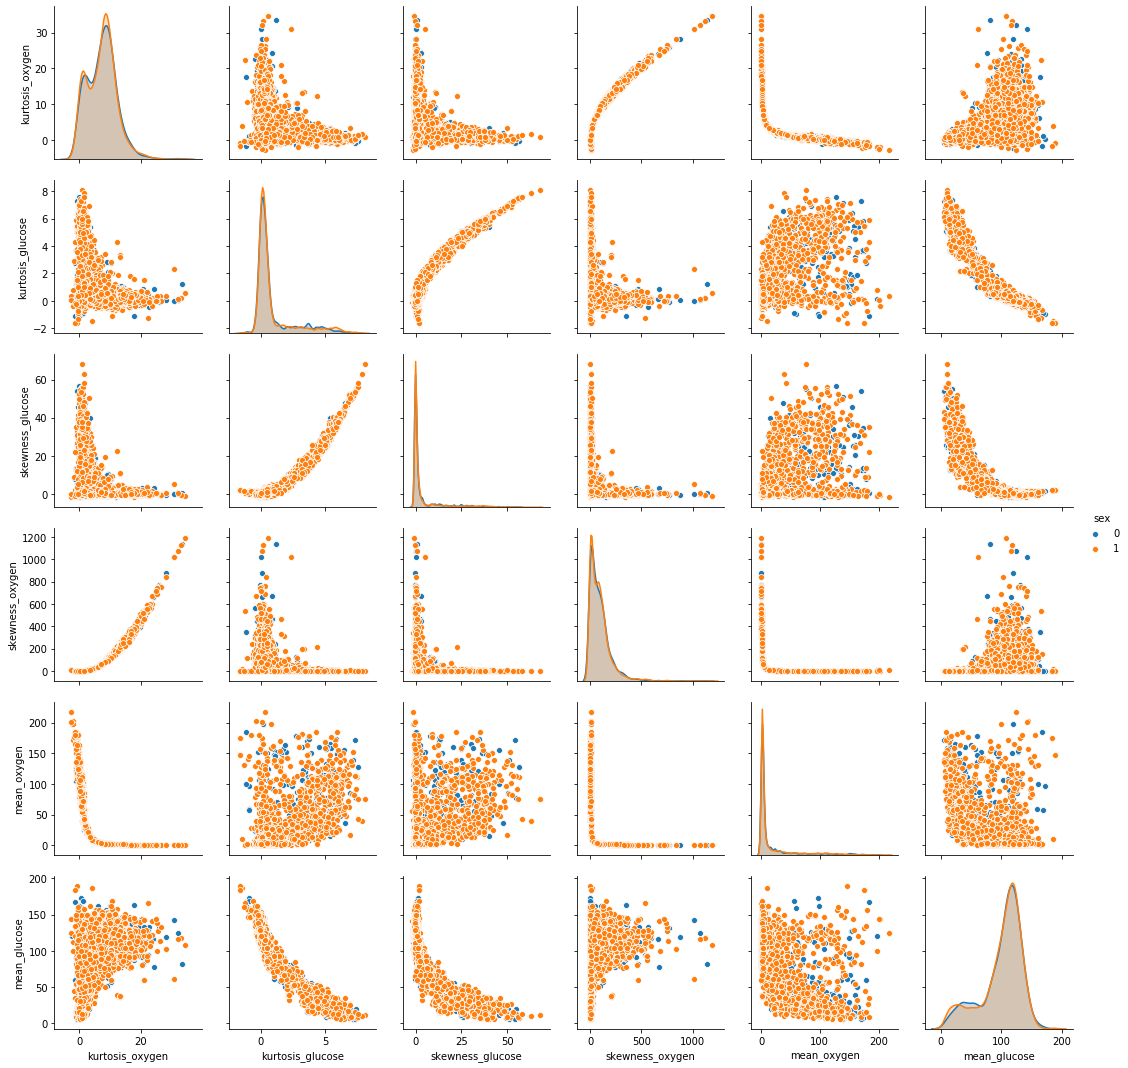

In [9]:
sns.pairplot(data, vars=['kurtosis_oxygen','kurtosis_glucose', 'skewness_glucose', 'skewness_oxygen', 'mean_oxygen', 'mean_glucose'], hue="sex", diag_kind="kde")

Vidime, ze pravdepodobne pohlavie nema ziaden vplyv na hodnotu tychto atributov.

#### Atribut age<br>
Ako aj v prvom odovzdani spracuvame age na ciselny atribut a jeho zaporne hodnoty nahradime NaN

In [10]:
data.age = data.age.map(sanitize_age)

In [11]:
len(data[pd.isnull(data.age)])

756

Po spracovani vsak mame vela prazdnych hodnot (756).<br>
Napada nas sposob vypocet nahradenim podla datumu, ale nemame zatial rozparsovany atribut date of birth.
<br>

Mohli by sme nahradit chybajuce hodnoty pacienta priemerom veku jeho pohlavia.
Pokial by pacient nemal uvedene pohlavie, nahradili by sme primerom vsetkych pacientov. Tuto funkciu si naprogramujeme, a uvidime ci sa bude dat pouzit neskor.

In [12]:
def fill_null_age(data): 
	unique_sexes = data.sex.unique()
	for sex in unique_sexes:
		mean = data.loc[(data.age.notnull()) & (data.sex == sex)].age.mean()
		data.loc[(data.sex == sex) & (data.age.isna()),'age'] = mean
	return data	

#### Atribut pregnant<br>
Upravime boolean hodnoty a nahradime ich ciselnou reprezentaciou.
<br>Taktiez vsetkym muzom nastavime pregnant na 0

In [13]:
def sanitize_boolean(boolean):
    try:
        if boolean.strip() in ['f','F','FALSE','false','False']:
            return 0
        elif boolean.strip() in ['t','T','TRUE','true','True']:
            return 1
        else:
            return np.nan
    except AttributeError:
        return np.nan

In [14]:
data.pregnant = data.pregnant.map(sanitize_boolean)

In [15]:
def sanitize_pregnancy(data):
    data.loc[(data.sex == 1),'pregnant'] = 0
    return data

data = sanitize_pregnancy(data)

Po vycisteni atributu pregnant by sme mohli v pripade ak nejaky zaznam ma chybajuci atribut sex a zaroven ma pregnant 1 -  nastavit ako sex ako zenu (0).
V tomto datasete take nemame, ale je dobre pripravit nasu funkciu just in case.

In [16]:
def sanitize_pregnancy(data):
	data.loc[(data.sex == 1),'pregnant'] = 0
	data.loc[(data.sex.isnull()) & (data.pregnant == 1),'sex'] = 0
	return data

data = sanitize_pregnancy(data)	

Vidime ze v datasete mame aj prazdne hodnoty, budeme sa tym zaoberat neskor

In [17]:
print(data.pregnant.unique())
data.pregnant.isnull().sum()

[ 0.  1. nan]


1

#### Atribut personal info<br>
Vyparsujeme vsetky hodnoty z tohto stringu a vytvorime nove columny

In [18]:
parsed_info = data.personal_info.map(parse_personal_info).map(remove_empty)

In [19]:
personal_info_columns = ['employment','country','relationship_info','employment_info','race']
for index,name in enumerate(personal_info_columns):
    data[name] = parsed_info.map(lambda x: fill_value(index,x))
	
data = data.drop('personal_info', axis=1)

In [20]:
data[personal_info_columns].head(5)

,employment,country,relationship_info,employment_info,race
0,Transport-moving,United-States,Divorced,Private,White
1,Adm-clerical,United-States,Divorced,Private,White
2,Prof-specialty,United-States,Married-civ-spouse,Private,White
3,Prof-specialty,United-States,Married-civ-spouse,State-gov,White
4,Tech-support,United-States,Never-married,Private,White


#### Atribut date of birth<br>
Z prvotnej analyzy vieme ze date of birth nema unifikovany tvar datumu, cize bude nutne ho osetrit.

In [21]:
def sanitize_date(date):
    date = str(date).replace('/', '-')
    date = date[:10]
    date = date.split("-")
    
    if date[0] != 'nan':
        if len(date[0]) != 4:
            if len(date[2]) == 2 and int(date[0]) > 31:
                new_date = "19"+ date[0] +"-"+date[1]+"-"+date[2] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) > 31)):
                new_date = "19"+date[2]+"-"+date[1]+"-"+date[0] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) < 31)):
                new_date = "20"+ date[2] + "-" +date[1]+"-" + date[0] 
            else:
                new_date = date[2]+"-"+date[1]+"-"+date[0] 
            return new_date        
    return '-'.join(date)

In [22]:
data.date_of_birth = data.date_of_birth.map(sanitize_date)
data.date_of_birth.head(5)

0    1960-07-04
1    1972-07-20
2    1960-02-28
3    1967-12-04
4    1938-04-22
Name: date_of_birth, dtype: object

Vidime, ze datumy maju uz rovnaky format. Teraz sa mozme vratit k upravovaniu atributu age - vypocitat chybajuce hodnoty na zaklade datumu.

### Dopocitanie veku na zaklade datumu

Prejdeme vsetky datumy a najdeme najfrekventovanejsi rok po scitani veku a roku narodenia. To je rok, v ktorom bolo uskutocnene meranie (supis) veku.
Tento rok vyuzijeme na dopocitanie veku osob na zaklade ich datumu narodenia ktore ho nemaju.

In [23]:
years = [];

def store_measure_year(age,date):
    if (pd.notnull(age)):
        years.append(int(date.split('-')[0]) + age)
        
data.apply(lambda x: store_measure_year(x.age,x.date_of_birth),axis=1)

measure_year = pd.Series(years).mode();

In [24]:
def fill_null_age(age,date):
    if (date):
        return (measure_year - int(date.split('-')[0]))[0]
    return np.nan

data.loc[data.age.isnull(),'age'] = data[data.age.isnull()].apply(lambda x: fill_null_age(x.age,x.date_of_birth),axis=1)

Podarilo sa nam vsetkym zaznamom dopocitat vek.

In [25]:
len(data[data.date_of_birth.isnull()])

0

Nastastie nemame ziadne take ze bez datumu a bez veku.

In [26]:
len(data[(data.date_of_birth.isna()) & (data.age.isnull())])

0

In [27]:
data['age'].describe()

count    3983.000000
mean       51.807432
std        11.804103
min        -1.000000
25%        44.000000
50%        52.000000
75%        60.000000
max       114.000000
Name: age, dtype: float64

Bohuzial, ako mozme vidiet, sice pri sanitizovani veku sme negativne age nahradili nan, ale opat po vypocte datumu sa nam tam objavilo. Znamena to ze mame asi nejaky nespravny datum.

In [28]:
data.loc[(data.age < 0)].date_of_birth

452    2020-09-17
Name: date_of_birth, dtype: object

Mozme vidiet ze naozaj, mame zly datum narodenia aj age. Navrhujeme nahradit teda hodnotu age priemerom jeho pohlavia.

In [29]:
sex_mean = data[(data.age > 0)].groupby('sex', as_index=False).age.mean()
data.loc[(data.age < 0),'age'] = data[data.age < 0].age.map(lambda a: round(sex_mean.loc[1,'age'],1))

In [30]:
data['age'].describe()

count    3983.000000
mean       51.820738
std        11.774394
min         3.000000
25%        44.000000
50%        52.000000
75%        60.000000
max       114.000000
Name: age, dtype: float64

Ked uz mame vyrieseny vek, pozrieme sa ako zavisi hodnota merani cukru a kysliku v krvi od veku.

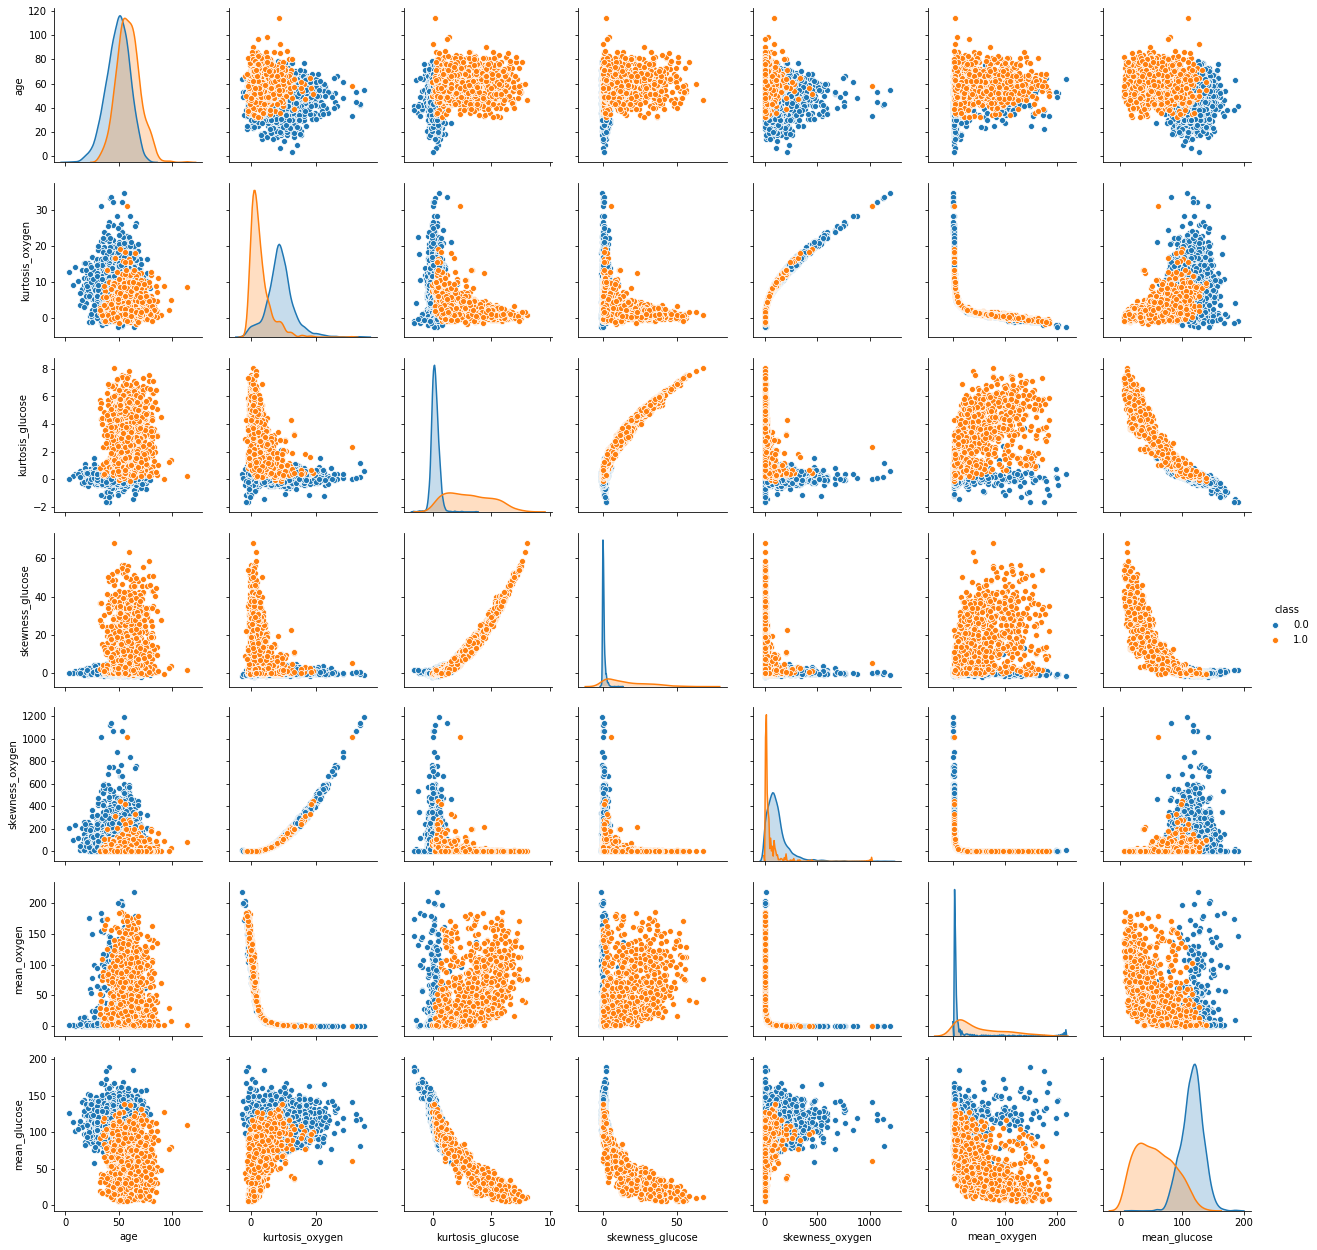

In [31]:
sns.pairplot(data, vars=['age','kurtosis_oxygen','kurtosis_glucose', 'skewness_glucose', 'skewness_oxygen', 'mean_oxygen', 'mean_glucose'], hue="class", diag_kind="kde")

Dalo by sa povedat, ze hodnota predikovanej triedy zavisi aj nad veku. V nizkom veku pacienta (do max cca 22-25 rokov) sa nenachadza ziaden pacient s cukrovkou.

#### Atribut income
Prehodime kategoricke hodnoty na ciselnu reprezentaciu ('<=50K' == 0, '>50K' == 1)

In [32]:
data.income.unique()

array([' <=50K', ' >50K', nan], dtype=object)

In [33]:
data.income = data.income.map(lambda income: 0 if str(income).strip() == '<=50K' else 1 if str(income).strip() == '>50K' else np.nan)

In [34]:
data.income.unique()

array([ 0.,  1., nan])

#### String Atributy
Tieto atributy su stringove, viackrat duplicitne, skusime ich troska quickfixnut a zjednotit data

In [35]:
def strip_string(string):
    try:
        return str(string).strip()
    except AttributeError:
        return None

def sanitize_string(string):
    string = strip_string(string);
    if string in ['None','nan','??','?']:
        return None
    return string

def sanitize_multiword_string(string):
    try:
        return sanitize_string(string).replace('-',' ').replace('_',' ')
    except AttributeError:
        return None

for column in ['relationship','relationship_info','employment','employment_info']:
    data[column] = data[column].map(sanitize_multiword_string)
    print(column,': ',data[column].unique(),'\n')


relationship :  ['Not in family' 'Own child' 'Husband' 'Wife' 'Unmarried' 'Other relative'
 None] 

relationship_info :  ['Divorced' 'Married civ spouse' 'Never married' None 'Widowed'
 'Married spouse absent' 'Separated' 'Married AF spouse'] 

employment :  ['Transport moving' 'Adm clerical' 'Prof specialty' 'Tech support' None
 'Sales' 'Craft repair' 'Other service' 'Handlers cleaners'
 'Farming fishing' 'Exec managerial' 'Machine op inspct' 'Priv house serv'
 'Protective serv' 'Armed Forces'] 

employment_info :  ['Private' 'State gov' None 'Self emp not inc' 'Federal gov' 'Local gov'
 'Self emp inc' 'Without pay' 'Never worked'] 



In [36]:
print(len(data[data.relationship.isnull()]))
print(len(data[data.relationship_info.isnull()]))

13
12


Velmi ma zaujali atributy relationship a relationship_info, a rad by som doplnil ich nejake prazdne hodnoty. 

Najskor by som asi zjednotil hodnoty 'Married civ spouse','Married AF spouse','Married spouse absent', na 'Married', vsak to je asi jedno za koho je zenaty/vydata. Teda vlasne iba ten treti typ to vyhral, ten ma o problem postarane.<br>
<img src="http://m.quickmeme.com/img/db/dbd8d8db8056e48ac72fd40435157978a1bbf2b63b297b41a9ba4302ed9962e0.jpg" height=200 width=200 align="left">

In [37]:
data.loc[data.relationship_info.str.contains('Married',na=False),'relationship_info'] = data[data.relationship_info.str.contains('Married',na=False)].relationship_info.map(lambda x: 'Married')

Dalsie co mozeme urobit je ze ak ma dany clovek relationship_info Never married, tak relationship mozme nastavit na Unmarried.

In [38]:
def sanitize_relationship(relationship,relationship_info):
    if relationship_info == 'Never married':
            return 'Unmarried'
    return relationship
    
data.loc[data.relationship.isnull(),'relationship'] = data[data.relationship.isnull()].apply(lambda row: sanitize_relationship(row.relationship,row.relationship_info), axis=1)

Este jedna vec nas napada, a to ti, ktori maju Husband alebo Wife v relationship, tak im implicitne dame Married.

In [39]:
def sanitize_relationship_info(relationship,relationship_info):
    if relationship in ['Wife','Husband']:
            return 'Married'
    return relationship_info
    
data.loc[data.relationship_info.isnull(),'relationship_info'] = data[data.relationship_info.isnull()].apply(lambda row: sanitize_relationship_info(row.relationship,row.relationship_info), axis=1)

Mozno este ti co maju relationship Married tak sa pozriet na ich pohlavie a podla toho dat Wife alebo Husband? (No nechceme to hrotit, takze to necháme tak)

In [40]:
print(data[data.relationship.isnull()].relationship_info,'\n')
print(data[data.relationship_info.isnull()].relationship)

1132        None
1442     Married
1516    Divorced
1837        None
2018        None
3161     Married
3162     Married
3449     Married
3801     Married
3963     Married
Name: relationship_info, dtype: object 

1009    Not in family
1132             None
1535    Not in family
1837             None
2018             None
2506        Unmarried
Name: relationship, dtype: object


Pozrieme sa este na country a education:

In [41]:
for column in ['country','education','race']:
    data[column] = data[column].map(sanitize_string)
    print(column,': ',data[column].unique(),'\n')

country :  ['United-States' None 'El-Salvador' 'South' 'Germany' 'Mexico' 'Cuba'
 'Philippines' 'England' 'Ireland' 'Canada' 'China' 'France' 'Japan'
 'India' 'Scotland' 'Italy' 'Puerto-Rico' 'Portugal' 'Jamaica' 'Thailand'
 'Dominican-Republic' 'Nicaragua' 'Poland' 'Peru' 'Vietnam' 'Ecuador'
 'Iran' 'Columbia' 'Laos' 'Guatemala' 'Hong' 'Haiti'
 'Outlying-US(Guam-USVI-etc)' 'Honduras' 'Cambodia' 'Taiwan' 'Greece'
 'Trinadad&Tobago' 'Yugoslavia'] 

education :  ['HS-grad' 'Bachelors' 'Some-college' '10th' 'Assoc-acdm' 'Masters' None
 '1st-4th' '7th-8th' 'Prof-school' '11th' '5th-6th' 'Assoc-voc' '9th'
 'Doctorate' '12th' 'Preschool'] 

race :  ['White' None 'Asian-Pac-Islander' 'Black' 'Other' 'Amer-Indian-Eskimo'] 



### Odstranenie duplikatov

Rozhodli sme sa odstranit duplikaty na zaklade mena, adresy a datumu narodenia.

In [42]:
print('length other:',len(data_other))
print('length personal',len(data_personal))

length other: 3983
length personal 3933


In [43]:
print('length data',len(data))

length data 3983


In [44]:
print('length duplicated before: ',len(data[data.duplicated(['name','address','date_of_birth'])]))
data = data.drop_duplicates(['name','address','date_of_birth'],keep="last")
print('length data',len(data))
print('length duplicated after: ',len(data[data.duplicated(['name','address','date_of_birth'])]))

length duplicated before:  50
length data 3933
length duplicated after:  0


### Chybajuce hodnoty

Tu vidíme v ktorých stĺpcoch potrebujeme doplniť hodnoty. Využijeme viacero metód - knn, linearnu regresiu, vyplnenie medianom. Hodnoty za pomoci ktorých budeme predikovať musia mať istú koreláciu aby boli spravne.

In [45]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

kurtosis_oxygen        2
pregnant               1
education-num         10
relationship           6
skewness_glucose      12
mean_glucose           4
std_oxygen            10
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
mean_oxygen            8
hours-per-week         8
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      237
race                   9
dtype: int64

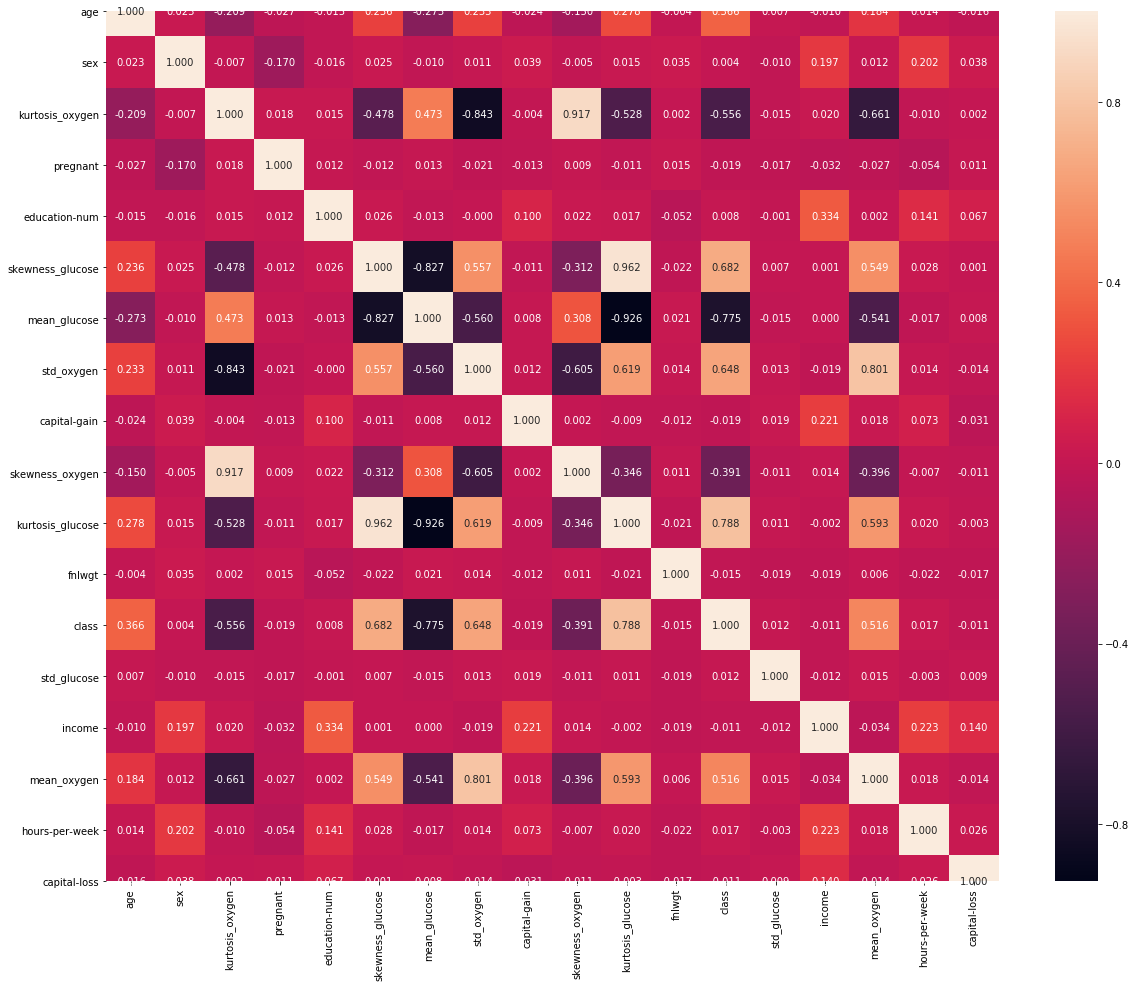

In [46]:
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(data.corr(),ax=ax, annot =True, fmt = ".3f")

### Predikcia kurtosis oxygen na základe mean_glucose a std_glucose

In [47]:
print('Chybajuce hodnoty kurtosis oxygen:', len(data[data.kurtosis_oxygen.isnull()]))

Chybajuce hodnoty kurtosis oxygen: 2


In [48]:
from sklearn.preprocessing import Imputer
from sklearn import linear_model

imp_median = Imputer(missing_values='NaN', strategy='median')

C:\Users\rusna\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Ako možeme vidieť korelácie medyi atribútmi sú vysoké, takže môžeme predpokladať vyššiu úspešnosť.

In [49]:
data['std_oxygen'] = imp_median.fit_transform(data[['std_oxygen']])
data['mean_oxygen'] = imp_median.fit_transform(data[['mean_oxygen']])
data[['kurtosis_oxygen','std_oxygen','mean_oxygen']].astype('float64').corr()


C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,kurtosis_oxygen,std_oxygen,mean_oxygen
kurtosis_oxygen,1.000000,-0.842162,-0.660024
std_oxygen,-0.842162,1.000000,0.801301
mean_oxygen,-0.660024,0.801301,1.000000


In [50]:
print(data.mean_oxygen.isnull().sum())
print(data.std_oxygen.isnull().sum())

0
0


In [51]:
fin = data.kurtosis_oxygen.dropna()
fin.head()

0     5.190414
1    10.079446
2     9.967118
3    12.175754
4     0.942381
Name: kurtosis_oxygen, dtype: float64

In [52]:
X = data[['std_oxygen','mean_oxygen']].head(fin.count())
y = fin
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
print('Úspešnosť doplnenia: ',lm.score(X,y), )
missing_kurtosis_oxygen = data[['std_oxygen','mean_oxygen']].loc[data['kurtosis_oxygen'].isna()]
predictions = lm.predict(missing_kurtosis_oxygen)
predictions

Úspešnosť doplnenia:  0.3146106334538543


array([9.03597604, 1.9881909 ])

In [53]:
missing = data.kurtosis_oxygen.isna()
onlyNans = data[missing]
data.loc[onlyNans.kurtosis_oxygen.index,'kurtosis_oxygen'] = predictions

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [54]:
print('Chybajuce hodnoty kurtosis oxygen:', len(data[data.kurtosis_oxygen.isnull()]))

Chybajuce hodnoty kurtosis oxygen: 0


### Doplnenie education-num
Kedze v prvom odovzdani - analyze sme zistili a potvrdili ze tieto dva atributy su na sebe zavisle a education-num je len ciselnou reprezentaciou education-u, doplnime education-num na zaklade atributu education.

In [55]:
print('Chybajuce hodnoty education-num:', len(data[data['education-num'].isnull()]))

Chybajuce hodnoty education-num: 10


In [56]:
data.education.unique()

array(['HS-grad', 'Bachelors', 'Some-college', '10th', 'Assoc-acdm',
       'Masters', '1st-4th', '7th-8th', 'Prof-school', '11th', '5th-6th',
       'Assoc-voc', '9th', 'Doctorate', '12th', 'Preschool', None],
      dtype=object)

In [57]:
def get_education_num(education):
    temp = 10.0
    for en in data['education-num'].loc[data.education == education]:
        if (en > 0) & (en < temp):
            temp = en
#     return temp if temp is not 1000 else return np.nan 
    return temp


dic = {}
for e in data.education.unique():
    dic[e] = (get_education_num(e))

In [58]:
print(dic)

{'HS-grad': 9.0, 'Bachelors': 10.0, 'Some-college': 10.0, '10th': 6.0, 'Assoc-acdm': 10.0, 'Masters': 10.0, '1st-4th': 2.0, '7th-8th': 4.0, 'Prof-school': 10.0, '11th': 7.0, '5th-6th': 3.0, 'Assoc-voc': 10.0, '9th': 5.0, 'Doctorate': 10.0, '12th': 8.0, 'Preschool': 1.0, None: 10.0}


In [59]:
data.loc[:,'education-num'] = data.education.map(dic)

In [60]:
print('Chybajuce hodnoty education-num:', len(data[data['education-num'].isnull()]))
print('Chybajuce hodnoty education:', len(data[data['education'].isnull()]))

# arr1 = data[data['education-num'].isnull()].index
# arr2 = data[data['education'].isnull()].index

# print(arr1 == arr2)

Chybajuce hodnoty education-num: 0
Chybajuce hodnoty education: 6


Podarilo sa nam doplnit teda zopar hodnot, okrem tych ktore nemaju ani education-num ani education

### Doplnenie hodnout employment_info a employment pomocou knn

In [61]:
print(len(data[(data.employment.isnull()) & (data['employment_info'].notnull())]))

1


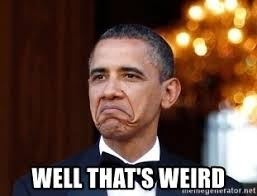

In [62]:
data.loc[data['employment'].isnull(), 'employment_info'] = None

In [63]:
print(len(data[(data.employment.isnull()) & (data['employment_info'].notnull())]))

0


<img src="https://twitchy.com/wp-content/uploads/2016/07/obama-thats-better_new.jpg" align="left" width="250">

In [64]:
from sklearn.neighbors import KNeighborsClassifier

df = data[['education', 'education-num', 'age', 'hours-per-week', 'employment_info', 'employment']]
df

,education,education-num,age,hours-per-week,employment_info,employment
0,HS-grad,9.0,59.0,40.0,Private,Transport moving
1,HS-grad,9.0,47.0,45.0,Private,Adm clerical
2,Bachelors,10.0,59.0,40.0,Private,Prof specialty
3,HS-grad,9.0,51.0,40.0,State gov,Prof specialty
4,Some-college,10.0,81.0,16.0,Private,Tech support
...,...,...,...,...,...,...
3978,Bachelors,10.0,50.0,40.0,Private,Craft repair
3979,HS-grad,9.0,52.0,20.0,None,None
3980,11th,7.0,58.0,40.0,Private,Machine op inspct
3981,Assoc-acdm,10.0,68.0,45.0,Private,Adm clerical


In [65]:
chopped = df.dropna(axis = 0, how = "any")

In [66]:
X = np.array(chopped[['education-num', 'age', 'hours-per-week']])
X

array([[ 9., 59., 40.],
       [ 9., 47., 45.],
       [10., 59., 40.],
       ...,
       [ 7., 58., 40.],
       [10., 68., 45.],
       [10., 60., 40.]])

In [67]:
Y = np.array(chopped[['employment_info', 'employment']])
Y

array([['Private', 'Transport moving'],
       ['Private', 'Adm clerical'],
       ['Private', 'Prof specialty'],
       ...,
       ['Private', 'Machine op inspct'],
       ['Private', 'Adm clerical'],
       ['Private', 'Tech support']], dtype=object)

In [68]:
example = np.array(df[['education-num', 'age', 'hours-per-week']].iloc[df.index == 3979])
print(example)
example

[[ 9. 52. 20.]]


array([[ 9., 52., 20.]])

In [69]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, Y)

prf = knn.predict(example.reshape(1, -1))
prf

array([['Private', 'Prof specialty']], dtype=object)

In [70]:
data['age'] = data['age'].astype(int)
data['education-num'] = data['education-num'].astype(int)
data['hours-per-week'] = imp_median.fit_transform(data[['hours-per-week']])

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [71]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant               1
relationship           6
skewness_glucose      12
mean_glucose           4
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      238
race                   9
dtype: int64

In [72]:
to_be_filled = data[['education', 'education-num', 'age', 'hours-per-week', 'employment_info', 'employment']].loc[data['employment_info'].isnull() == True]

dic_work = {}

to_be_filled = (to_be_filled.iloc[:, 1:4])

to_be_filled = np.array(to_be_filled)

predicted = knn.predict(to_be_filled)
predicted

array([['Private', 'Sales'],
       ['Private', 'Transport moving'],
       ['Private', 'Other service'],
       ['Private', 'Other service'],
       ['Private', 'Craft repair'],
       ['Private', 'Adm clerical'],
       ['Private', 'Craft repair'],
       ['Federal gov', 'Sales'],
       ['Federal gov', 'Craft repair'],
       ['Private', 'Adm clerical'],
       ['Private', 'Exec managerial'],
       ['Private', 'Prof specialty'],
       ['Private', 'Sales'],
       ['Private', 'Craft repair'],
       ['Private', 'Other service'],
       ['Private', 'Craft repair'],
       ['Private', 'Adm clerical'],
       ['Private', 'Handlers cleaners'],
       ['Private', 'Craft repair'],
       ['Private', 'Craft repair'],
       ['Private', 'Prof specialty'],
       ['Private', 'Adm clerical'],
       ['Private', 'Prof specialty'],
       ['Local gov', 'Adm clerical'],
       ['Private', 'Other service'],
       ['Private', 'Exec managerial'],
       ['Local gov', 'Adm clerical'],
       ['Pri

In [73]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant               1
relationship           6
skewness_glucose      12
mean_glucose           4
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      238
race                   9
dtype: int64

In [74]:

df_predicted = pd.DataFrame(predicted)
df_predicted


,0,1
0,Private,Sales
1,Private,Transport moving
2,Private,Other service
3,Private,Other service
4,Private,Craft repair
5,Private,Adm clerical
6,Private,Craft repair
7,Federal gov,Sales
8,Federal gov,Craft repair
9,Private,Adm clerical


In [75]:
data['employment_info'].loc[data['employment_info'].isnull() == True] = df_predicted[0].values

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
data['employment'].loc[data['employment'].isnull() == True] = df_predicted[1].values

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant              1
relationship          6
skewness_glucose     12
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64

In [78]:
data['skewness_oxygen'].unique()

array([ 29.33438934, 119.4506868 , 119.7982303 , ...,  78.49212012,
         0.48247399,  61.69992429])

### Doplnenie skewness_glucose

hodnoty skewness_glucose dopĺňame na základe korelácie s kurtosis_glucose. Využili sme linernu regresiu na doplnenie hodnôt.

In [79]:
import sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
df = data[['kurtosis_glucose','skewness_glucose']]
df.dropna(axis=0, how='any', inplace=True)
X = df['kurtosis_glucose'].values.reshape(-1,1)


lm.fit(X,df['skewness_glucose'])
data_null = data['kurtosis_glucose'].loc[(data['skewness_glucose'].isna()) & (~data['kurtosis_glucose'].isna())]
data_null
temp = lm.predict(np.array(data_null).reshape(-1,1))
temp
data['skewness_glucose'].loc[(data['skewness_glucose'].isna()) & (~data['kurtosis_glucose'].isna())] = temp

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


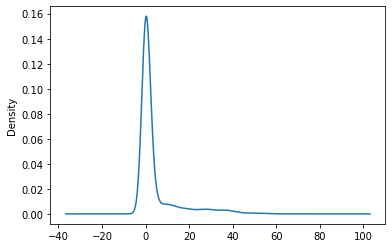

In [80]:
import copy
Zaloha = copy.deepcopy(data['skewness_glucose'])
PomDF = copy.deepcopy(data['skewness_glucose'])
PomDF.fillna(PomDF.mean(), inplace=True)
PomDF.plot(kind='kde')

In [81]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant              1
relationship          6
skewness_glucose      3
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64

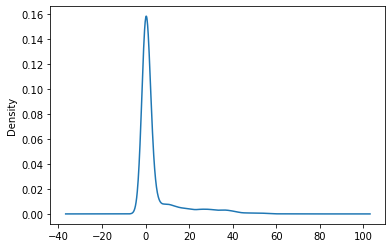

In [82]:
data['skewness_glucose'].plot(kind='kde')

Vidíme, že nám zostali ešte nejaké nevplnené hodnoty, ktoré doplníme priemerom

In [83]:
 data['skewness_glucose'].isna().sum()

3

In [84]:
linearRegressionWM = copy.deepcopy(data['skewness_glucose'])
linearRegressionWM

0      -0.043867
1       0.923553
2       0.060398
3      -0.583193
4       3.656040
          ...   
3978    2.375737
3979    0.158678
3980   -0.475804
3981    7.695857
3982    1.254641
Name: skewness_glucose, Length: 3933, dtype: float64

In [85]:
data['skewness_glucose'].fillna(data['skewness_glucose'].mean(),inplace=True)

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [86]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant              1
relationship          6
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64

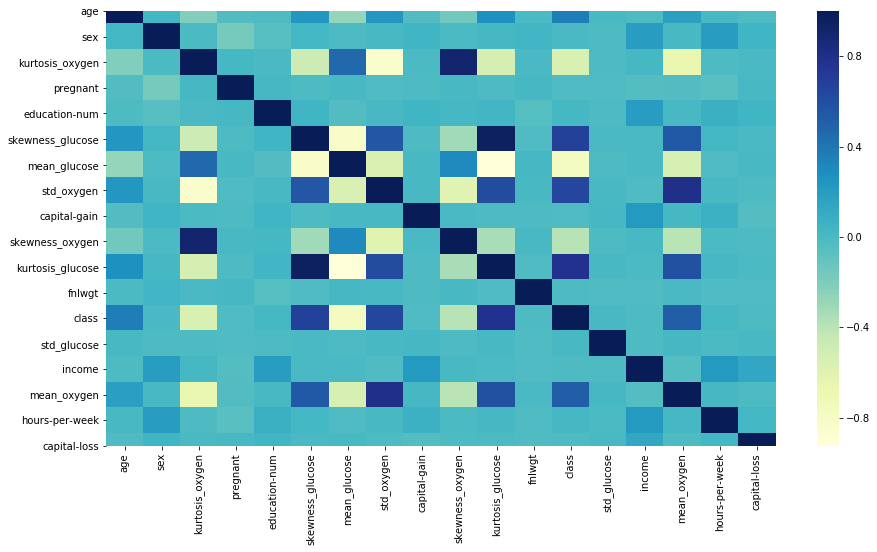

In [87]:
corr = data.corr()
plt.subplots(figsize=(15,8))
sns.heatmap(corr, cmap="YlGnBu",xticklabels=corr.columns, yticklabels=corr.columns)

Na Heatmape sme našli korelácie viacerých atribútov, hlavne:

- korelácia hodnôt skewness_glucose a std_oxygen okolo hodnoty 0.5
- Môžme vidieť aj koreláciu hodnôt mean_oxygen a mean_glucose
- Slabšiu koreláciu vidno aj medzi age a class prip. kurtosis_glucose

Snazili sme sa najst koreláciu medzi kategorickými hodnotami atribútmi a classou no nenasli sme nic zaujimaveho.

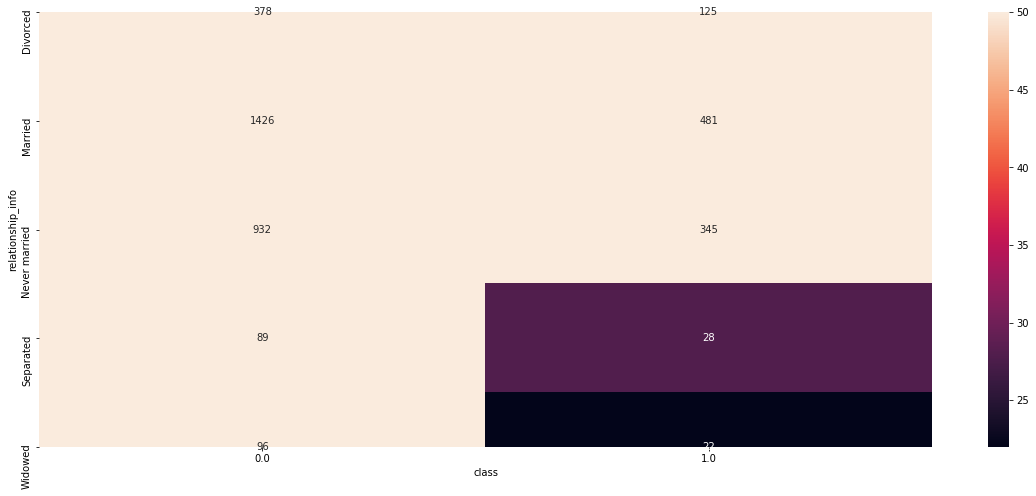

In [88]:
table = pd.crosstab(index = data['relationship_info'], columns = data['class'])


plt.subplots(figsize=(20,8))
sns.heatmap(table, vmax = 50, annot = True, fmt = "")

In [89]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant              1
relationship          6
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64

### Pregnant 
Pozrieme sa aký riadok prislúcha nulovej hodnote pregnant.

In [90]:
data[data.pregnant.isnull()]

,name,address,age,sex,date_of_birth,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,...,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,employment,country,relationship_info,employment_info,race
2003,Joshua Sanders,0629 Trevor Inlet Suite 858\r\nHarrisonborough...,37,0,1982-05-19,11.938502,NaN,10,Unmarried,-0.368959,...,55.480443,0.0,1.644649,40.0,0.0,Sales,United-States,Divorced,Private,White


In [91]:
from sklearn.neighbors import KNeighborsClassifier

df = data[['education', 'education-num', 'age', 'hours-per-week', 'sex', 'pregnant']]
df

,education,education-num,age,hours-per-week,sex,pregnant
0,HS-grad,9,59,40.0,1,0.0
1,HS-grad,9,47,45.0,0,0.0
2,Bachelors,10,59,40.0,1,0.0
3,HS-grad,9,51,40.0,0,0.0
4,Some-college,10,81,16.0,0,0.0
...,...,...,...,...,...,...
3978,Bachelors,10,50,40.0,1,0.0
3979,HS-grad,9,52,20.0,0,0.0
3980,11th,7,58,40.0,0,0.0
3981,Assoc-acdm,10,68,45.0,0,0.0


In [92]:
chopped = df.dropna(axis = 0, how = "any")
chopped

,education,education-num,age,hours-per-week,sex,pregnant
0,HS-grad,9,59,40.0,1,0.0
1,HS-grad,9,47,45.0,0,0.0
2,Bachelors,10,59,40.0,1,0.0
3,HS-grad,9,51,40.0,0,0.0
4,Some-college,10,81,16.0,0,0.0
...,...,...,...,...,...,...
3978,Bachelors,10,50,40.0,1,0.0
3979,HS-grad,9,52,20.0,0,0.0
3980,11th,7,58,40.0,0,0.0
3981,Assoc-acdm,10,68,45.0,0,0.0


In [93]:
X = np.array(chopped[['education-num', 'age', 'hours-per-week','sex']])
X

array([[ 9., 59., 40.,  1.],
       [ 9., 47., 45.,  0.],
       [10., 59., 40.,  1.],
       ...,
       [ 7., 58., 40.,  0.],
       [10., 68., 45.,  0.],
       [10., 60., 40.,  1.]])

In [94]:
Y = np.array(chopped[['pregnant']])
Y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [95]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, Y)


C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [96]:
to_be_filled = data[['education-num', 'age', 'hours-per-week', 'sex','pregnant']].loc[data['pregnant'].isnull() == True]


to_be_filled = (to_be_filled[['education-num', 'age', 'hours-per-week', 'sex']])
# to_be_filled = to_be_filled.dropna()
to_be_filled = np.array(to_be_filled)
to_be_filled
predicted = knn.predict(to_be_filled)
predicted

array([0.])

In [97]:

df_predicted = pd.DataFrame(predicted)
df_predicted

,0
0,0.0


In [98]:
data['pregnant'].loc[data['pregnant'].isnull() == True] = df_predicted[0].values

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Vidíme, že po predikcie sme sa zbavili nulových hodnôt pre stlpec pregnant

In [99]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

relationship          6
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64

### relationship a relationship_info
V tomto stlpci nám chýba 6 hodnôt. Rozhodli sme sa tieto hodnoty nastaviť na uknown pretože nevieme aký majú dôvod toho prečo to nie je uvedené.

In [100]:
data[data.relationship.isnull()]

,name,address,age,sex,date_of_birth,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,...,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,employment,country,relationship_info,employment_info,race
1132,David Muller,"96941 Heather Heights\r\nPetersonberg, OK 45722",67,1,1952-11-03,-0.936519,0.0,9,None,15.942676,...,41.582231,0.0,159.611204,40.0,0.0,Machine op inspct,None,None,Private,None
1516,Leslie Marks,"657 Williams Lakes\r\nNew Jessica, SC 19216",47,0,1972-10-18,7.708201,0.0,10,None,-0.351233,...,52.182663,0.0,3.227425,50.0,NaN,Prof specialty,United-States,Divorced,Private,White
2018,Kenneth Green,1381 Schneider Common Apt. 574\r\nSouth Nichol...,39,0,1979-11-21,9.766992,0.0,10,None,-0.397321,...,53.789052,0.0,3.227425,50.0,NaN,Exec managerial,None,None,Private,None
3162,Carl Gross,"765 Cruz Walks\r\nBentleyburgh, IN 37147",46,1,1973-08-06,8.359921,0.0,9,None,0.535185,...,47.606505,0.0,2.897993,40.0,0.0,Sales,United-States,Married,Private,White
3449,Bert Fowler,"83987 Smith Mall\r\nPort Cynthia, NY 01518",58,1,1961-09-07,2.225273,0.0,10,None,3.739947,...,47.029319,1.0,26.102007,40.0,0.0,Prof specialty,United-States,Married,Private,White
3963,John Jaffe,"PSC 3677, Box 2117\r\nAPO AE 28076",30,1,1989-01-17,6.023659,0.0,9,None,1.906458,...,NaN,0.0,3.227425,40.0,0.0,Machine op inspct,United-States,Married,Federal gov,White


In [101]:
data[data.relationship_info.isnull()]

,name,address,age,sex,date_of_birth,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,...,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,employment,country,relationship_info,employment_info,race
1009,Christopher Jennings,"09825 Brian Freeway\r\nEast Austinborough, AR ...",55,1,1963-11-12,1.333386,0.0,9,Not in family,-1.168893,...,65.026730,0.0,40.698997,75.0,0.0,Craft repair,None,None,Private,None
1132,David Muller,"96941 Heather Heights\r\nPetersonberg, OK 45722",67,1,1952-11-03,-0.936519,0.0,9,None,15.942676,...,41.582231,0.0,159.611204,40.0,0.0,Machine op inspct,None,None,Private,None
1535,Robert Barnett,"70417 Rodgers Gardens Apt. 766\r\nSarahport, N...",53,1,1966-05-08,3.874827,0.0,10,Not in family,4.222238,...,35.224583,0.0,12.570234,40.0,0.0,Adm clerical,None,None,Private,None
2018,Kenneth Green,1381 Schneider Common Apt. 574\r\nSouth Nichol...,39,0,1979-11-21,9.766992,0.0,10,None,-0.397321,...,53.789052,0.0,3.227425,50.0,NaN,Exec managerial,None,None,Private,None


In [102]:
data.relationship_info.replace([np.nan],['Unknown'], inplace=True)

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [103]:
df = data[['education-num', 'sex', 'age', 'relationship_info', 'relationship']]
chopped = df.dropna(axis = 0, how = "any")
chopped

,education-num,sex,age,relationship_info,relationship
0,9,1,59,Divorced,Not in family
1,9,0,47,Divorced,Own child
2,10,1,59,Married,Husband
3,9,0,51,Married,Wife
4,10,0,81,Never married,Not in family
...,...,...,...,...,...
3978,10,1,50,Married,Not in family
3979,9,0,52,Married,Wife
3980,7,0,58,Divorced,Unmarried
3981,10,0,68,Never married,Not in family


In [104]:
X = np.array(chopped[['education-num','sex', 'age']])
Y = np.array(chopped[['relationship']])

In [105]:

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, Y)

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [106]:
to_be_filled = data[['education-num', 'sex', 'age', 'relationship_info', 'relationship']].loc[data['relationship'].isnull() == True]


to_be_filled = (to_be_filled[['education-num','sex', 'age']])
to_be_filled = np.array(to_be_filled)
to_be_filled
predicted = knn.predict(to_be_filled)
predicted

array(['Husband', 'Not in family', 'Not in family', 'Husband', 'Husband',
       'Husband'], dtype=object)

In [107]:
df_predicted = pd.DataFrame(predicted)
df_predicted

,0
0,Husband
1,Not in family
2,Not in family
3,Husband
4,Husband
5,Husband


In [108]:
data['relationship'].loc[data['relationship'].isnull() == True] = df_predicted[0].values

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

mean_glucose         4
capital-gain         8
skewness_oxygen      5
kurtosis_glucose     7
education            6
fnlwgt               6
class                8
std_glucose          6
income               7
capital-loss        12
country             74
race                 9
dtype: int64

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 28 columns):
name                 3933 non-null object
address              3933 non-null object
age                  3933 non-null int32
sex                  3933 non-null int64
date_of_birth        3933 non-null object
kurtosis_oxygen      3933 non-null float64
pregnant             3933 non-null float64
education-num        3933 non-null int32
relationship         3933 non-null object
skewness_glucose     3933 non-null float64
mean_glucose         3929 non-null float64
std_oxygen           3933 non-null float64
capital-gain         3925 non-null float64
skewness_oxygen      3928 non-null float64
kurtosis_glucose     3926 non-null float64
education            3927 non-null object
fnlwgt               3927 non-null float64
class                3925 non-null float64
std_glucose          3927 non-null float64
income               3926 non-null float64
mean_oxygen          3933 non-null float64
h

### Class

In [111]:
df = data[['mean_glucose', 'sex', 'age', 'mean_oxygen', 'class']]
chopped = df.dropna(axis = 0, how = "any")
chopped

,mean_glucose,sex,age,mean_oxygen,class
0,125.679688,1,59,5.914716,0.0
1,116.492188,0,47,2.192308,0.0
2,112.796875,1,59,2.127090,0.0
3,123.875000,0,51,1.627090,0.0
4,75.679688,0,81,64.813545,1.0
...,...,...,...,...,...
3978,86.578125,1,50,1.307692,0.0
3979,135.804688,0,52,1.239130,0.0
3980,133.882812,0,58,2.816890,0.0
3981,60.414062,0,68,178.700669,1.0


In [112]:
X = np.array(chopped[['mean_glucose', 'sex', 'age', 'mean_oxygen']])
Y = np.array(chopped[['class']])

In [113]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, Y)

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [114]:
to_be_filled = data[['mean_glucose', 'sex', 'age', 'mean_oxygen', 'class']].loc[data['class'].isnull() == True]


to_be_filled = (to_be_filled[['mean_glucose', 'sex', 'age', 'mean_oxygen']])
to_be_filled = np.array(to_be_filled)
to_be_filled
predicted = knn.predict(to_be_filled)
predicted

array([0., 1., 0., 1., 0., 0., 0., 0.])

In [115]:
df_predicted = pd.DataFrame(predicted)
df_predicted

,0
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0
5,0.0
6,0.0
7,0.0


In [116]:
data['class'].loc[data['class'].isnull() == True] = df_predicted[0].values

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [117]:
data['class'].isnull().sum()

0

### Do ostatných hodnôt priradíme priemer z daných stlpcov alebo najfrekventovanejšiu hodnotu
Využívame na to funckie MyImputer_num a MyImputer_cat, ktoré doplňajú hodnoty všetkým stĺpcom, buď priemerom alebo najfrekventovanejšou hodnotou.


In [118]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

mean_glucose         4
capital-gain         8
skewness_oxygen      5
kurtosis_glucose     7
education            6
fnlwgt               6
std_glucose          6
income               7
capital-loss        12
country             74
race                 9
dtype: int64

In [119]:
from sklearn.base import TransformerMixin

class MyImputer_num(TransformerMixin):
    
    def __init__(self, missing_value=np.nan):
        self.missing_value = missing_value
        self.mean = 0
        
    def _get_mask(self, X, value_to_mask):
        if np.isnan(value_to_mask):
            return np.isnan(X);
        else:
            return np.equal(X, value_to_mask)
        
    
    def fit(self, X, y=None):        
        mask = self._get_mask(X, self.missing_value)
        self.mean = np.mean(X[~mask])
        return self
        
    
    def transform(self, X):
        mask = self._get_mask(X, self.missing_value)
        X[mask] = self.mean
        
        return X

In [120]:
categorical_columns = [  'capital-loss', 'income', 'std_glucose', 'fnlwgt', 'kurtosis_glucose', 'skewness_oxygen', 'capital-gain', 'mean_glucose']
my_imp_num = MyImputer_num()
for col in categorical_columns:
    my_imp_num.fit(data[col])
    data[col] = my_imp_num.transform(data[col])

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.

In [121]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

education     6
country      74
race          9
dtype: int64

In [122]:
from sklearn.base import TransformerMixin
class MyImputer_cat(TransformerMixin):

    def __init__(self):
        """
        Impute missing values.
        """


    def fit(self, X, y=None):
        self.fill = X.value_counts().index[0]
        
        return self

    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [123]:
categorical_columns = ['education','country','race']
my_imp_cat = MyImputer_cat()
for col in categorical_columns:
    my_imp_cat.fit(data[col])
    data[col] = my_imp_cat.transform(data[col])

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


V tabulke nevidíme žiadne prázdne hodnoty, to nám značí, že sme všetky prázdne hodnoty odstránili.

In [124]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

Series([], dtype: float64)

### Odstranovanie vychýlených hodnôt

Prejdeme si všetky stlpce ako sú na tom vychýlené hodnoty a potom využije tuto funckiu.
Vo funkcii sa využíva transformácia pomocou logaritmu a zároveň 5 a 95 percentil.
Dole nižšie sú znazornené grafy pred a po odstranení outlierov. Vidíme tam ako sa zmenilo rozloženie histogramu a rozprestretie boxplotu.


In [125]:
def use_quantiles(df, column):
    new_df = df.copy(deep = True)
    skew_val = stats.skew(new_df[column]) 
    
    if ((skew_val < -2) or (skew_val > 2)):  
        minimum = new_df[column].min()
        minimum = minimum + (-minimum - minimum)
        new_df[column] = np.log(new_df[column]+minimum)
    
    perc_95 = new_df[column].quantile(.95)   
    perc_05 =  new_df[column].quantile(.05)
    new_df.loc[new_df[column] < perc_05, column] = perc_05
    new_df.loc[new_df[column] > perc_95, column] = perc_95
    return new_df

### kurtosis_oxygen


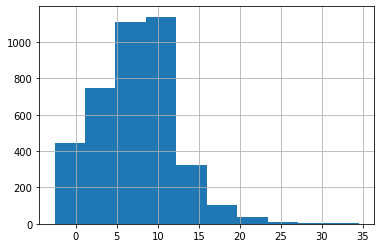

In [126]:
data['kurtosis_oxygen'].hist()

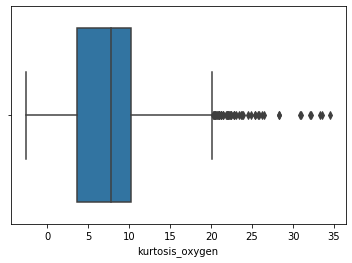

In [127]:

sns.boxplot(data['kurtosis_oxygen'])

In [128]:
data = use_quantiles(data, 'kurtosis_oxygen')


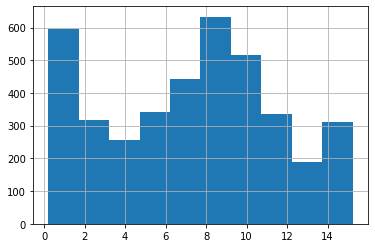

In [129]:
data['kurtosis_oxygen'].hist()

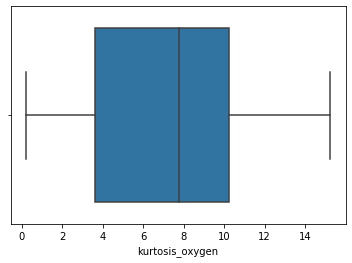

In [130]:

sns.boxplot(data['kurtosis_oxygen'])

### skewness_glucose


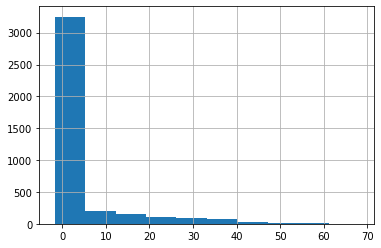

In [131]:
data['skewness_glucose'].hist();

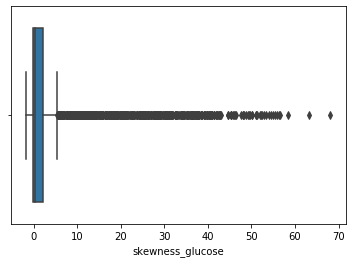

In [132]:

sns.boxplot(data['skewness_glucose'])

In [133]:
data = use_quantiles(data, 'skewness_glucose')


C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


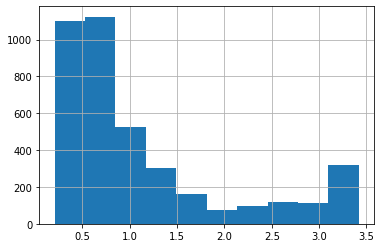

In [134]:
data['skewness_glucose'].hist();

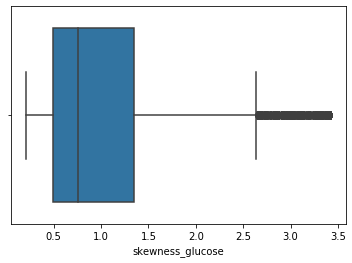

In [135]:

sns.boxplot(data['skewness_glucose'])

### mean_glucose

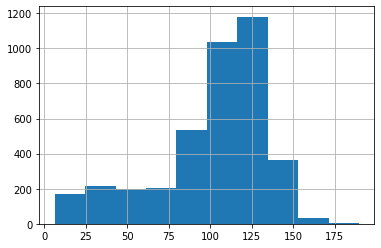

In [136]:
data['mean_glucose'].hist();

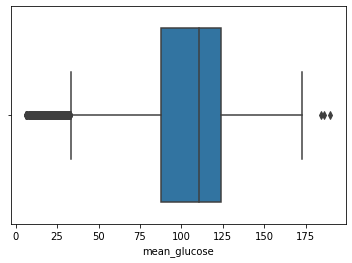

In [137]:

sns.boxplot(data['mean_glucose'])

In [138]:
data = use_quantiles(data, 'mean_glucose')


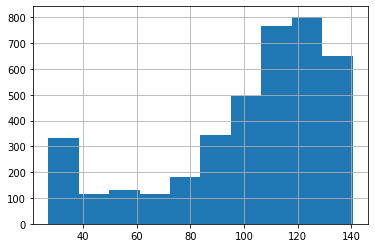

In [139]:
data['mean_glucose'].hist();

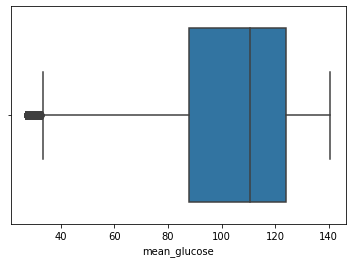

In [140]:

sns.boxplot(data['mean_glucose'])

### mean_oxygen         

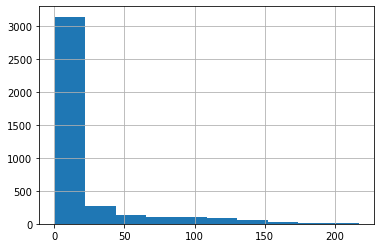

In [141]:
data['mean_oxygen'].hist();

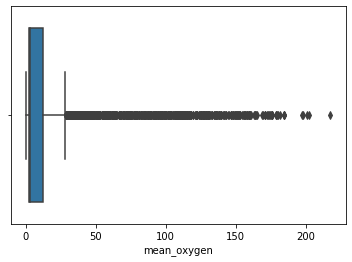

In [142]:
sns.boxplot(data['mean_oxygen'])

In [143]:
data = use_quantiles(data, 'mean_oxygen')


C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


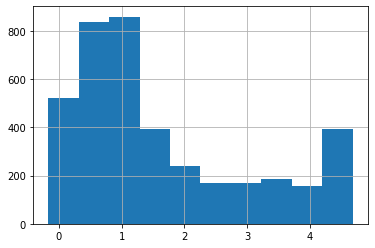

In [144]:
data['mean_oxygen'].hist();

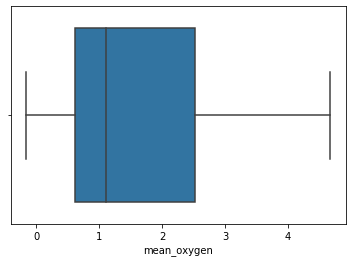

In [145]:
sns.boxplot(data['mean_oxygen'])

### std_oxygen           

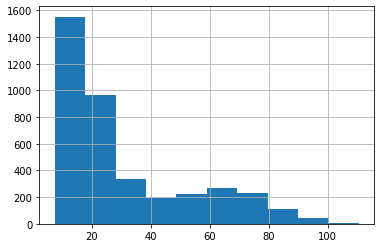

In [146]:
data['std_oxygen'].hist();

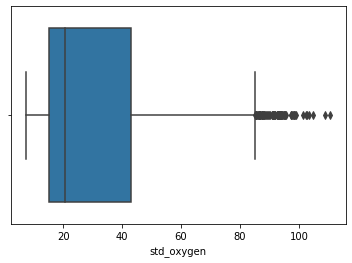

In [147]:

sns.boxplot(data['std_oxygen'])

In [148]:
data = use_quantiles(data, 'std_oxygen')


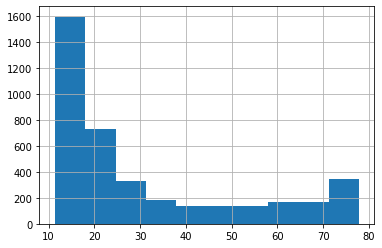

In [149]:
data['std_oxygen'].hist();

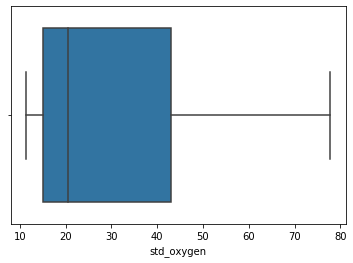

In [150]:

sns.boxplot(data['std_oxygen'])

### skewness_oxygen      

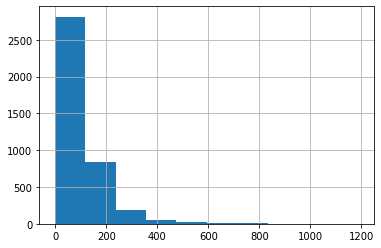

In [151]:
data['skewness_oxygen'].hist();

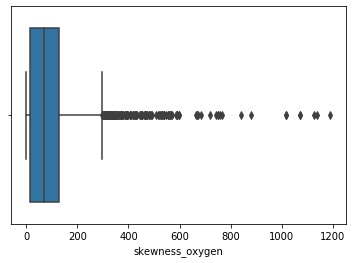

In [152]:

sns.boxplot(data['skewness_oxygen'])

In [153]:
data = use_quantiles(data, 'skewness_oxygen')


C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


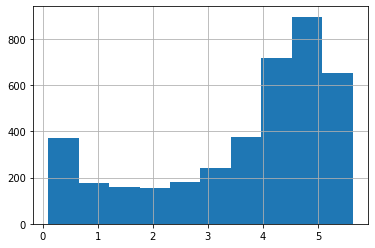

In [154]:
data['skewness_oxygen'].hist();

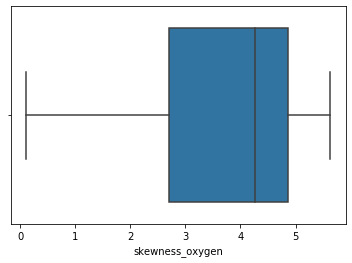

In [155]:

sns.boxplot(data['skewness_oxygen'])

### kurtosis_glucose     

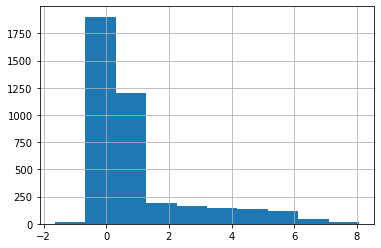

In [156]:
data['kurtosis_glucose'].hist();

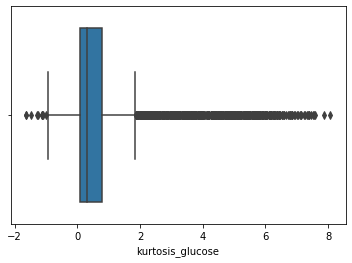

In [157]:

sns.boxplot(data['kurtosis_glucose'])

In [158]:
data = use_quantiles(data, 'kurtosis_glucose')


C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


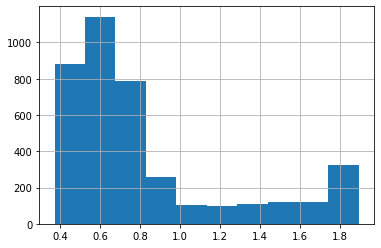

In [159]:
data['kurtosis_glucose'].hist();

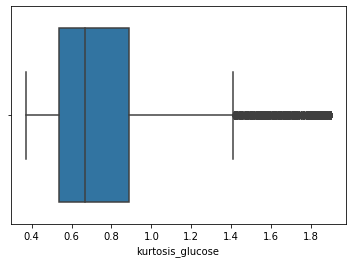

In [160]:

sns.boxplot(data['kurtosis_glucose'])

### fnlwgt               

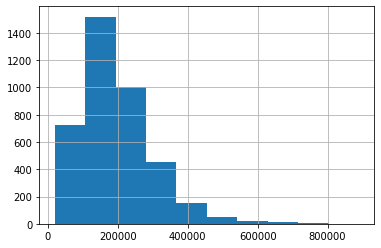

In [161]:
data['fnlwgt'].hist();

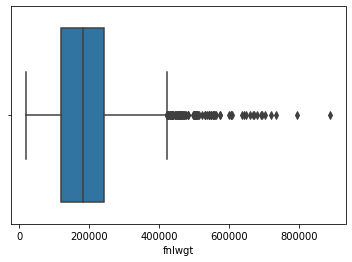

In [162]:
sns.boxplot(data['fnlwgt'])

In [163]:
data = use_quantiles(data, 'fnlwgt')


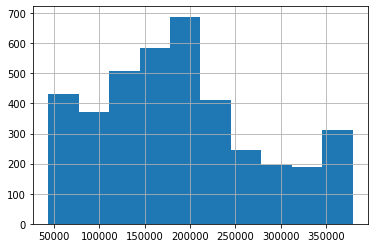

In [164]:
data['fnlwgt'].hist();

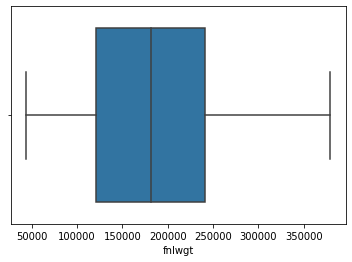

In [165]:
sns.boxplot(data['fnlwgt'])

### std_glucose          

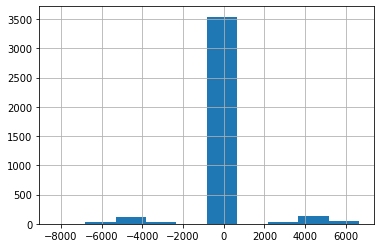

In [166]:
data['std_glucose'].hist();

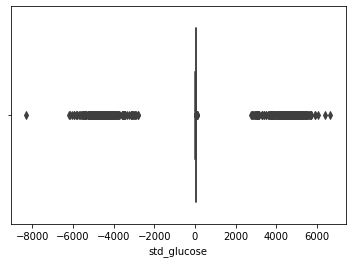

In [167]:
sns.boxplot(data['std_glucose'])

In [168]:
data = use_quantiles(data, 'std_glucose')


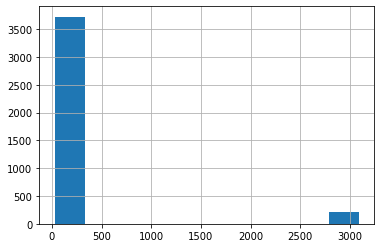

In [169]:
data['std_glucose'].hist();

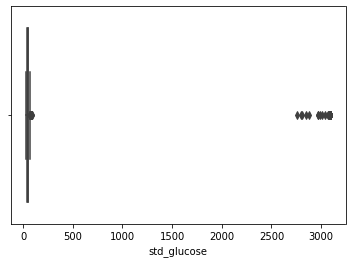

In [170]:
sns.boxplot(data['std_glucose'])

## Opätovná realizácia podstatných častí prieskumnej analýzy

Zmenil sa nam počet stĺpcov, vytvorili sme nove stlpce parsovanim komplexnych hodnot

In [171]:
print('Pocet stlpcov teraz:',data.shape[1], '  Pocet stlpcov pred:', data_bf.shape[1])

Pocet stlpcov teraz: 28   Pocet stlpcov pred: 29


 Zmenil sa nam počet aj zaznamov, navysil sa vplyvom mergnutia a nasledne sa znizil vplyvom deduplikovania zaznamov.

In [172]:
print('Pocet stlpcov teraz:',data.shape[0], '  Pocet stlpcov pred:', data_bf.shape[0])

Pocet stlpcov teraz: 3933   Pocet stlpcov pred: 3983


Porovannie počtu dátových typov

In [173]:
datatypes = pd.DataFrame({'Pred upravami' : data_bf.dtypes.value_counts(), 'Po úpravách' : data.dtypes.value_counts()})
datatypes

,Pred upravami,Po úpravách
int32,NaN,2
int64,1.0,1
float64,16.0,15
object,12.0,10


Môžeme vidieť v tabuľke, že zmeni ktoré sme urobili, zmenili len v malej miere celkové výsledky nad datasetom. V niektorých riadkoch, kde nebolo až toľko chybových hodnôt a toľko prázdnych hodnôt, sa media a priemer zmenili iba málo.

In [174]:
df=pd.DataFrame({"Priemer predtým":data_bf.mean(),"Median predtým":data_bf.median(),"Priemer potom":data.mean(),"Median potom":data.median()})
df

,Priemer predtým,Median predtým,Priemer potom,Median potom
age,51.947319,52.000000,51.866006,52.000000
capital-gain,1042.988908,0.000000,1048.462420,0.000000
capital-loss,80.275549,0.000000,81.135425,0.000000
class,0.255298,0.000000,0.255276,0.000000
education-num,10.084489,10.000000,9.098144,10.000000
fnlwgt,192967.197985,182045.000000,189288.300744,182123.000000
hours-per-week,40.568766,40.000000,40.541317,40.000000
income,NaN,NaN,0.247071,0.000000
kurtosis_glucose,0.950507,0.310372,0.824711,0.669606
kurtosis_oxygen,7.414473,7.784802,7.261342,7.782188


## Porovnanie so starým datasetom
Samostatne porovnávame len tie atribúty pri ktorých bol velký počet chýbajúcich dát.
Všetko ostatné je zhrnúte na konci, pretože si myslíme, že pri velkosti datasetu ~4000, chýbajúce hodnoty o velkosti 1-10 nezmenia velmi vzhľad grafu.

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 28 columns):
name                 3933 non-null object
address              3933 non-null object
age                  3933 non-null int32
sex                  3933 non-null int64
date_of_birth        3933 non-null object
kurtosis_oxygen      3933 non-null float64
pregnant             3933 non-null float64
education-num        3933 non-null int32
relationship         3933 non-null object
skewness_glucose     3933 non-null float64
mean_glucose         3933 non-null float64
std_oxygen           3933 non-null float64
capital-gain         3933 non-null float64
skewness_oxygen      3933 non-null float64
kurtosis_glucose     3933 non-null float64
education            3933 non-null object
fnlwgt               3933 non-null float64
class                3933 non-null float64
std_glucose          3933 non-null float64
income               3933 non-null float64
mean_oxygen          3933 non-null float64
h

In [176]:
data_bf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 29 columns):
name                 3983 non-null object
address              3983 non-null object
age                  3227 non-null float64
sex                  3983 non-null int64
date_of_birth        3983 non-null object
kurtosis_oxygen      3978 non-null float64
pregnant             3982 non-null float64
education-num        3965 non-null float64
relationship         3970 non-null object
skewness_glucose     3960 non-null float64
mean_glucose         3973 non-null float64
std_oxygen           3969 non-null float64
capital-gain         3967 non-null float64
skewness_oxygen      3970 non-null float64
kurtosis_glucose     3965 non-null float64
personal_info        3971 non-null object
education            3971 non-null object
fnlwgt               3970 non-null float64
class                3964 non-null float64
std_glucose          3971 non-null float64
income               3969 non-null object

## Pohlavie - sex

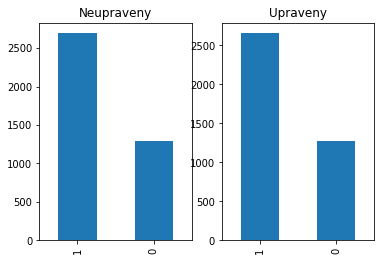

In [177]:
fig1, axes15 = plt.subplots(1, 2)

data_bf.sex.value_counts().plot.bar(ax=axes15[0])
data.sex.value_counts().plot.bar(ax=axes15[1])
ax=axes15[0].set_title('Neupraveny')
ax=axes15[1].set_title('Upraveny')

In [178]:
print("Predtym: ", data_bf.sex.value_counts())
print("Potom: ", data.sex.value_counts())

Predtym:  1    2692
0    1291
Name: sex, dtype: int64
Potom:  1    2655
0    1278
Name: sex, dtype: int64


V mraci atributu sex sa nezmenilo nič, iba počet hodnôt po dropnuti duplicatov.

### Datum narodenia  - date_of_birth

In [179]:
data_bf.date_of_birth.head(10)

0             1960-07-04
1             1972-07-20
2             1960-02-28
3             1967-12-04
4             1938-04-22
5             02/01/1969
6             1967-04-30
7    1957-03-08 00:00:00
8             1980-04-06
9             1986-08-26
Name: date_of_birth, dtype: object

In [180]:
data.date_of_birth.head(10)

0    1960-07-04
1    1972-07-20
2    1960-02-28
3    1967-12-04
4    1938-04-22
5    1969-01-02
6    1967-04-30
7    1957-03-08
8    1980-04-06
9    1986-08-26
Name: date_of_birth, dtype: object

Zjednotenie datumu na rovnaký formát.

### Vek -age

In [181]:

data.age.describe()

count    3933.000000
mean       51.866006
std        11.781328
min         3.000000
25%        44.000000
50%        52.000000
75%        60.000000
max       114.000000
Name: age, dtype: float64

In [182]:
data_bf.age.describe()


count    3227.000000
mean       51.947319
std        11.669942
min         3.000000
25%        45.000000
50%        52.000000
75%        60.000000
max        99.000000
Name: age, dtype: float64

Vidíme že počet hodnot sa zmenil a menšie zmeni nastali aj pri priemere, maxime a minime.

### Employment 

In [183]:
data.employment.value_counts()

Prof specialty       568
Adm clerical         520
Craft repair         514
Exec managerial      495
Sales                458
Other service        438
Machine op inspct    241
Handlers cleaners    199
Transport moving     197
Farming fishing      120
Tech support          99
Protective serv       66
Priv house serv       17
Armed Forces           1
Name: employment, dtype: int64

In [184]:
data_bf.employment.value_counts()

Prof-specialty       488
Sales                450
Craft-repair         444
Exec-managerial      426
Adm-clerical         399
Other-service        367
None                 234
Machine-op-inspct    211
Transport-moving     183
Handlers-cleaners    176
Farming-fishing      111
Tech-support          81
Protective-serv       57
Exec_managerial       55
Prof_specialty        53
Craft_repair          46
Adm_clerical          46
Other_service         39
Machine_op_inspct     25
Tech_support          18
Handlers_cleaners     15
Priv-house-serv       14
Transport_moving      13
Protective_serv        9
Farming_fishing        7
Priv_house_serv        3
Armed-Forces           1
Name: employment, dtype: int64

Pri employment sme zjednotili názvy rovnakých prac, bol rozdiel v - a _ . Taktiež sme doplnili chýbajúce hodnoty. 

### Employment_info

In [185]:
data.employment_info.value_counts()

Private             2994
Self emp not inc     293
Local gov            237
State gov            148
Self emp inc         145
Federal gov          115
Without pay            1
Name: employment_info, dtype: int64

In [186]:
data_bf.employment_info.value_counts()

Private             2801
Self-emp-not-inc     293
None                 233
Local-gov            231
State-gov            150
Self-emp-inc         149
Federal-gov          112
Without-pay            1
Never-worked           1
Name: employment_info, dtype: int64

Doplnenie a zjednotenie informacií, niektoré mali rovnaký význam, tie sa zjednocovali. 


### Country

In [187]:
data.country.value_counts()

United-States                 3613
Mexico                          89
Germany                         17
Philippines                     16
India                           15
Canada                          15
England                         15
Puerto-Rico                     15
Cuba                            12
Dominican-Republic              11
Jamaica                         10
El-Salvador                      8
South                            7
Italy                            7
China                            7
Vietnam                          6
Taiwan                           6
Poland                           6
Guatemala                        5
Japan                            5
Columbia                         5
Iran                             5
France                           4
Portugal                         4
Ireland                          4
Greece                           3
Scotland                         3
Haiti                            3
Laos                

In [188]:
data_bf.country.value_counts()

United-States                 3582
Mexico                          90
None                            66
Canada                          17
Germany                         17
Philippines                     16
India                           15
England                         15
Puerto-Rico                     15
Cuba                            12
Dominican-Republic              11
Jamaica                         10
El-Salvador                      8
China                            7
Italy                            7
South                            7
Poland                           6
Taiwan                           6
Vietnam                          6
Guatemala                        5
Iran                             5
Japan                            5
Columbia                         5
Portugal                         4
Ireland                          4
France                           4
Laos                             3
Scotland                         3
Haiti               

Doplnenie chýbajúcich hodnôt. 

### Zaver
Podarilo sa nám spojiť datasety a deduplikovať záznamy. Doplniť chýbajúce hodnoty pomocou priemerov, 
závislostí na iných atribútoch i natrénovaných modeloch. Vytvorili sme funkcie ktoré transformujú a prečistia dáta. <br>
Na dopĺňanianie a opravu hodnôt sme využívali sme knn, priemer a lineárnu regresiu na dopĺnánie chýbajúcich hodnôt a opravu hodnôt, tiež máme funkcie na doplnenie priemerov a najväčšej frekvencie prvku.<br>
V rámci riešenia outlierov sme používali logaritmus a 5 a 95 percentil.
Celková zmena oproti starému neupravenému datasetu je jednak v počte riakov a stĺpcov. Taktiež vidíme zmeny v medianoch a priemeroch v celkovej tabuľku. 


### Zhodnotenie našej práce
Je veľa vecí ktoré by sme ešte prerobili do funkcií, aby to boli jednoduchšie na používanie a taktiež aby sa to dalo používať globálne. Tiež by sme spravili celkové prečistenie a doplnenie datasetu automatické, pokiaľ by sme neboli v časovej tiesni. Určite by to bolo prepracovanejšie a lepšie prezentované, ako opis tak aj kód ako taký. 
Taktiež by sme rozdelili hodnoty pri hodnotách mean,std,kurtosis a skewness na zdravých a chorých - upravili by sme funckiu aby vedela pracovať nad tým.